<a href="https://colab.research.google.com/github/austintaps/customer-churn/blob/main/ASSIGNMENT1%20XGBOOST%20MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
from google.colab import drive
#drive.mount("/content/drive")
#drive.mount("/content/drive", force_remount=true)

In [58]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [106]:
import pandas as pd
import numpy as np
import missingno as ms
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score,roc_auc_score,make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
%matplotlib inline
import param,numbergen
import seaborn as sns
from sklearn import model_selection, metrics  #to include metrics for evaluation # this used to be cross_validation

In [60]:
data=pd.read_csv('/content/drive/My Drive/Colab Notebooks/datasets_13996_18858_WA_Fn-UseC_-Telco-Customer-Churn (3).csv')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


PREPAIRING DATA FOR THE XGBOOST

In [61]:
# See if the data is usable.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [62]:
# Analyze if there is non-numeric data in the 'TotalCharges' column since it's showing as an object instead of float64.
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors = 'coerce')
data.loc[data['TotalCharges'].isna()==True]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


In [63]:
# Above we see that the blank "TotalCharges" happen when customers have 0 months tenure so we will change those values to $0.
data[data['TotalCharges'].isna()==True] = 0
data['OnlineBackup'].unique()

array(['Yes', 'No', 'No internet service', 0], dtype=object)

In [64]:
# See how many rows and columns.
data.shape

(7043, 21)

More data cleanup: next we’ll convert the categorical values into numeric values.



In [65]:
data['gender'].replace(['Male','Female'],[0,1],inplace=True)
data['Partner'].replace(['Yes','No'],[1,0],inplace=True)
data['Dependents'].replace(['Yes','No'],[1,0],inplace=True)
data['PhoneService'].replace(['Yes','No'],[1,0],inplace=True)
data['MultipleLines'].replace(['No phone service','No', 'Yes'],[0,0,1],inplace=True)
data['InternetService'].replace(['No','DSL','Fiber optic'],[0,1,2],inplace=True)
data['OnlineSecurity'].replace(['No','Yes','No internet service'],[0,1,0],inplace=True)
data['OnlineBackup'].replace(['No','Yes','No internet service'],[0,1,0],inplace=True)
data['DeviceProtection'].replace(['No','Yes','No internet service'],[0,1,0],inplace=True)
data['TechSupport'].replace(['No','Yes','No internet service'],[0,1,0],inplace=True)
data['StreamingTV'].replace(['No','Yes','No internet service'],[0,1,0],inplace=True)
data['StreamingMovies'].replace(['No','Yes','No internet service'],[0,1,0],inplace=True)
data['Contract'].replace(['Month-to-month', 'One year', 'Two year'],[0,1,2],inplace=True)
data['PaperlessBilling'].replace(['Yes','No'],[1,0],inplace=True)
data['PaymentMethod'].replace(['Electronic check', 'Mailed check', 'Bank transfer (automatic)','Credit card (automatic)'],[0,1,2,3],inplace=True)
data['Churn'].replace(['Yes','No'],[1,0],inplace=True)
 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   int64  
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   int64  
 4   Dependents        7043 non-null   int64  
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   int64  
 7   MultipleLines     7043 non-null   int64  
 8   InternetService   7043 non-null   int64  
 9   OnlineSecurity    7043 non-null   int64  
 10  OnlineBackup      7043 non-null   int64  
 11  DeviceProtection  7043 non-null   int64  
 12  TechSupport       7043 non-null   int64  
 13  StreamingTV       7043 non-null   int64  
 14  StreamingMovies   7043 non-null   int64  
 15  Contract          7043 non-null   int64  
 16  PaperlessBilling  7043 non-null   int64  


Our goal is to avoid multicollinearity by dropping features that are closely correlated with each other. For example here it is TotalCharges and MonthlyCharges. So we will drop TotalCharges.

In [66]:
data.pop('TotalCharges')

0         29.85
1       1889.50
2        108.15
3       1840.75
4        151.65
         ...   
7038    1990.50
7039    7362.90
7040     346.45
7041     306.60
7042    6844.50
Name: TotalCharges, Length: 7043, dtype: float64

In [67]:
# Run info again to make sure TotalCharges has been dropped (popped off).
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   int64  
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   int64  
 4   Dependents        7043 non-null   int64  
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   int64  
 7   MultipleLines     7043 non-null   int64  
 8   InternetService   7043 non-null   int64  
 9   OnlineSecurity    7043 non-null   int64  
 10  OnlineBackup      7043 non-null   int64  
 11  DeviceProtection  7043 non-null   int64  
 12  TechSupport       7043 non-null   int64  
 13  StreamingTV       7043 non-null   int64  
 14  StreamingMovies   7043 non-null   int64  
 15  Contract          7043 non-null   int64  
 16  PaperlessBilling  7043 non-null   int64  


In [68]:
# Explore how many churn data points we have.
print(len(data['Churn']))

7043


In [69]:
# Explore how many customers in this dataset have churned. Is this dataset 50% as the team suggests is the overall customer churn rate?  
data['Churn'].value_counts()
# We see this dataset actually has less than the overall 50% churn rate of the entire company reported data (it's actually 26.54% that have churned.

0    5174
1    1869
Name: Churn, dtype: int64

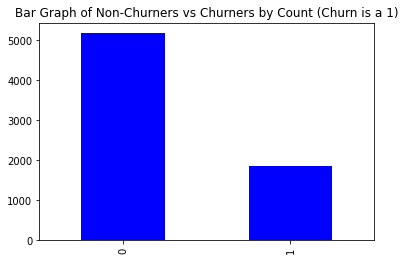

In [70]:
# This creates a bar graph of churn (Yes vs. No) so we can check how the data is balanced.
data['Churn'].value_counts().plot(kind = 'bar', title = 'Bar Graph of Non-Churners vs Churners by Count (Churn is a 1)', color = 'blue', align = 'center')
plt.show()
# The dataset does not have a huge imbalance which is good news! But also we clearly see it does not have the 50% as we would have thought. 

In [71]:
# Creates initial contingency table between Churn and gender. Male is 0, Female is 1.
gender_churn_contingency = pd.crosstab(data["gender"], data["Churn"])
display(gender_churn_contingency)
# Male and females churn at about the same rate, so not much to see here. Let's keep moving.

Churn,0,1
gender,,
0,2630,930
1,2544,939


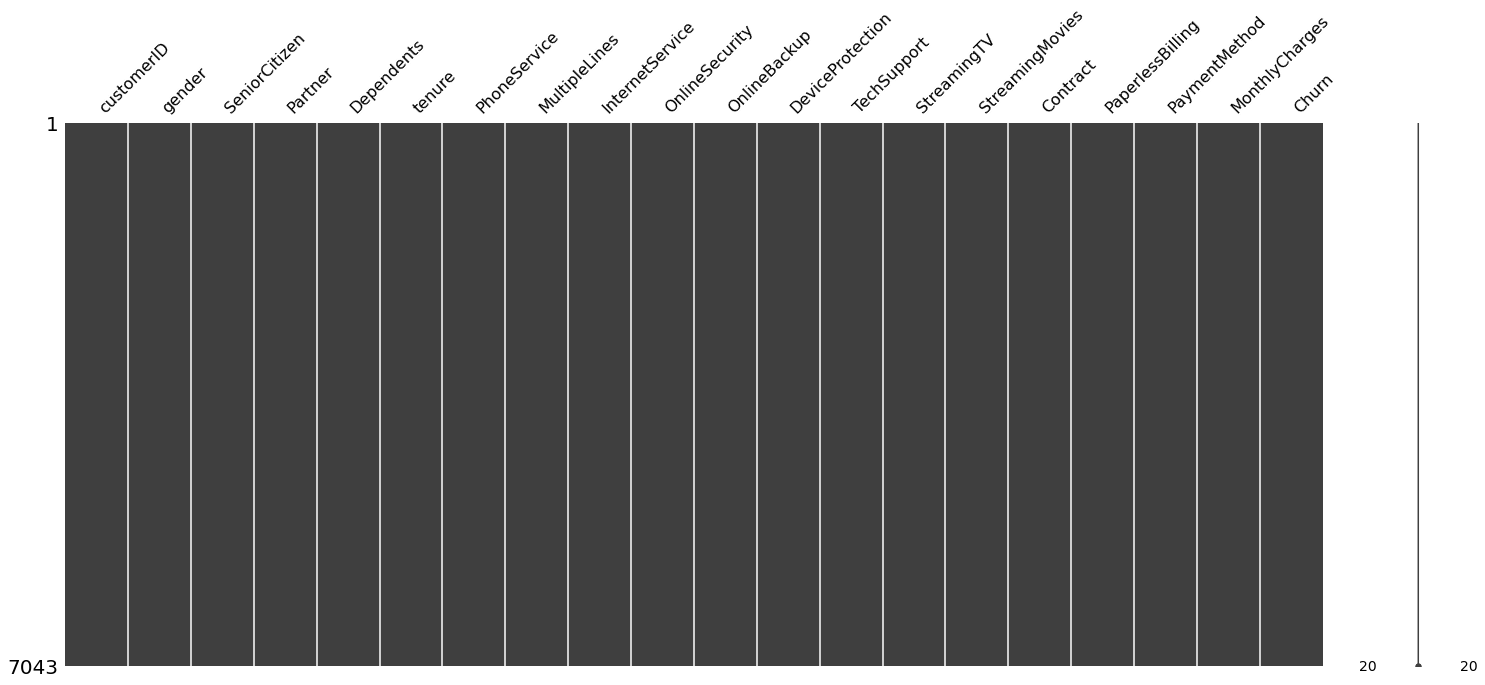

In [72]:
# Check the data health. The sections should all be completely black indicating the data is complete.
ms.matrix(data)
# It looks good.

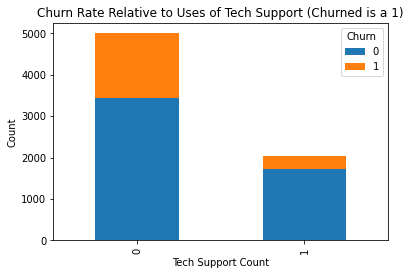

In [73]:
# Explore the relationship between instances of Tech Support and Churn. 
# Stacked Bar of Tech Support and Churn.
tech_support_churn = pd.crosstab(data['TechSupport'], data['Churn'])
tech_support_churn.plot(kind = 'bar', stacked = True)
plt.ylabel('Count')
plt.xlabel('Tech Support Count')
plt.title('Churn Rate Relative to Uses of Tech Support (Churned is a 1)')
plt.show()
# We can see that non-churners use tech support more often than customers that end up churning.
# So let's explore some ways to get people to use Tech Support more often so they cancel (churn) less. You can see notes for this at the bottom. 
# Also, tech support in this data is just a Y/N. It would be useful in future to include how many tech support calls by customer so we could analyze how the number of tech support calls relates to churn.

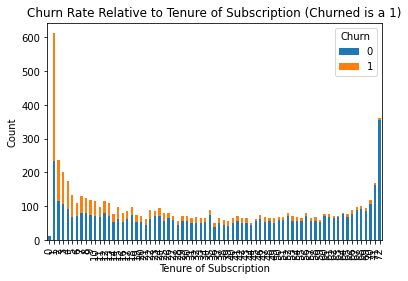

In [74]:
# Churn rate relative to tenure.
# Stacked bar of tenure and churn.
tenure_churn = pd.crosstab(data['tenure'], data['Churn'])
tenure_churn.plot(kind = 'bar', stacked = True)
plt.ylabel('Count')
plt.xlabel('Tenure of Subscription')
plt.title('Churn Rate Relative to Tenure of Subscription (Churned is a 1)')
plt.show()
# We can clearly see the longer a customer stays as a subscriber, the less they are likely to churn!

In [75]:
# Distribution of features.
features = ['gender', 'SeniorCitizen','Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges']
data[features].describe()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.494534,0.162147,0.481755,0.298026,32.371149,0.901888,0.421269,1.222206,0.286100,0.344314,0.343320,0.289649,0.383785,0.387761,0.687491,0.591793,1.313503,64.697004
std,0.500006,0.368612,0.499702,0.457424,24.559481,0.297487,0.493798,0.779535,0.451969,0.475178,0.474851,0.453632,0.486341,0.487274,0.832727,0.491537,1.149799,30.171186
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.450000
50%,0.000000,0.000000,0.000000,0.000000,29.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,70.350000
75%,1.000000,0.000000,1.000000,1.000000,55.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,89.850000
max,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,118.750000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


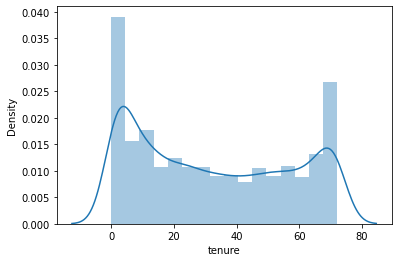

In [76]:
# Plot the distribution of observations for tenure.
sns.distplot(data['tenure']);
# It shows the max tenure is 70. This must be when the data history ends. We'll account for this in our analysis.

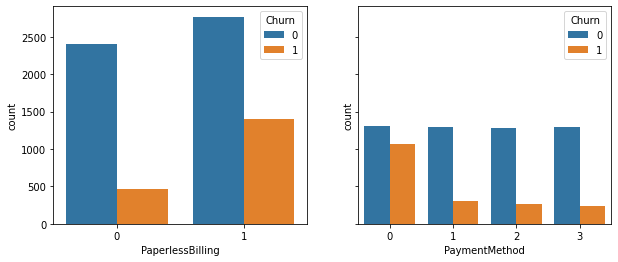

In [77]:
# Does how a customer pays have to do with their churn?
_, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 4)) 
sns.countplot(x='PaperlessBilling', hue='Churn',
              data=data, ax=axes[0]);
sns.countplot(x='PaymentMethod', hue='Churn',
              data=data, ax=axes[1]);
# We can see that customers that use paperless billing are much more likely to churn (0 = don't have paperless billing). That seems backwards I would go check that data with the team.
# We can see that customers that have the 0 payment method (electronic check) are much more likely to churn. Let's discourage that option.

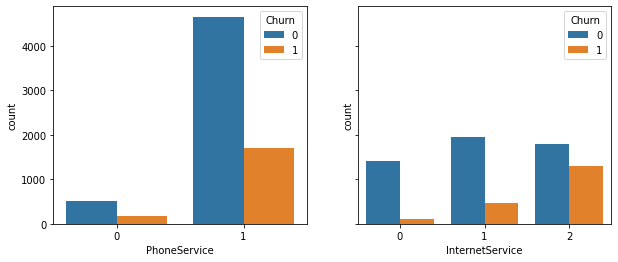

In [78]:
# See if the other products they have from this company has to do with their churn.
_, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 4)) 
sns.countplot(x='PhoneService', hue='Churn',
              data=data, ax=axes[0]);
sns.countplot(x='InternetService', hue='Churn',
              data=data, ax=axes[1]);
# If they don't have Phone Service, they are more likely to churn.
# If they don't have Internet Service, they are more likely to churn. Those customers with the highest Internet Service are least likely to churn.
# Conclusion: This makes sense. Customers with other products from the company, and premium products, churn less.
# Offer customers these additional products, perhaps even at a deep discount, so they take them and are less likely to churn. 

In [96]:
#SPLITING THE DATA FOR THE XGBOOST MODEL
X = data.drop('Churn',axis='columns')
y = data['Churn']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=5)

# Function to estimate the best value of n_estimators and fit the model with the given data.

In [80]:
train=pd.concat([X_train,y_train],axis=1)

In [81]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        #to get the parameters of xgboost
        xgb_param = alg.get_xgb_params() 
        
        #to convert into a datastructure internally used by xgboost for training efficiency 
        # and speed
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        
        #xgb.cv is used to find the number of estimators required for the parameters 
        # which are set
        cvresult = xgb.cv(xgb_param, xgtrain, 
                          num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                        metrics='auc', early_stopping_rounds=early_stopping_rounds)
        
        #setting the n_estimators parameter using set_params
        alg.set_params(n_estimators=cvresult.shape[0])
        
        print(alg.get_xgb_params())
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Churn'],eval_metric='auc')
    
    return alg

# Function to get the accuracy of the model on the test data given the features considered.

In [82]:
def get_accuracy(alg,predictors):
    dtrain_predictions = alg.predict(X_test[predictors])
    dtrain_predprob = alg.predict_proba(X_test[predictors])[:,1]
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(y_test.values, 
                                                      dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(y_test.values, 
                                                           dtrain_predprob))

In [83]:
def get_feature_importances(alg):
    #to get the feature importances based on xgboost we use fscore
    feat_imp = pd.Series(alg._Booster.get_fscore()).sort_values(ascending=False)
    print(feat_imp)
    
    #this shows the feature importances on a bar chart
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [84]:
target = 'Churn'
IDcol = 'customerID'

Model Selection, Predictions, and Metrics

In [85]:
!pip install xgboost
# XGBoost converts weak learners to strong learners through an ensemble method. 
# Unlike bagging, in the classical boosting the subset creation is not random and depends upon the performance of the previous models.

In [86]:
def XgbClass(learning_rate =0.1,n_estimators=1000,max_depth=5,min_child_weight=1,
             gamma=0,subsample=0.8,colsample_bytree=0.8):
    xgb1 = XGBClassifier(learning_rate=learning_rate,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         min_child_weight=min_child_weight,
                         gamma=gamma,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree)
    return xgb1

In [87]:
# These are the initial parameters before tuning.
def drop_features(l):
    return [x for x in train.columns if x not in l]

In [88]:
#First Prediction: Use of initial parameters and without feature engineering

In [89]:
from xgboost import XGBClassifier
import xgboost as xgb
predictors = drop_features([target, IDcol])
xgb1=XgbClass()
first_model=modelfit(xgb1, train, predictors)
xgb1.fit(train[predictors],train['Churn'])

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 37, 'nthread': 1, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'subsample': 0.8, 'verbosity': 1}


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=37, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [90]:
X_train.shape

(4930, 19)

In [91]:
X_test.shape

(2113, 19)

In [92]:
X_train[:10]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges
2823,4884-LEVMQ,0,0,1,0,39,1,0,0,0,0,0,0,0,0,2,1,2,20.45
3908,8261-GWDBQ,1,1,1,0,60,1,1,2,1,1,1,1,1,1,2,1,2,116.05
1539,5071-FBJFS,1,0,1,1,4,1,0,1,1,0,0,0,0,0,0,0,0,50.30
2792,9163-GHAYE,1,0,0,0,15,1,0,1,0,1,0,0,0,0,0,0,0,48.85
896,8975-SKGRX,0,0,1,0,71,1,1,2,1,1,1,1,1,1,2,1,2,116.10
6986,3976-BWUCK,1,0,1,0,30,1,1,2,0,1,0,1,1,0,0,1,3,94.10
5203,0734-OXWBT,0,0,0,1,3,1,0,1,0,0,0,1,1,1,0,0,1,70.70
1270,8780-IHCRN,0,0,1,1,63,1,1,0,0,0,0,0,0,0,2,0,3,24.65
6934,6257-DTAYD,0,0,1,0,71,1,1,2,0,1,0,1,1,1,2,1,3,104.15
3506,2916-BQZLN,0,0,0,0,19,1,1,2,1,0,1,0,0,0,0,1,0,84.75


In [93]:
len(X_train.columns)

19

#4 ACURACY EVALUATION OF THE DATA

In [99]:
!pip install xgboost
# XGBoost converts weak learners to strong learners through an ensemble method. 
# Unlike bagging, in the classical boosting the subset creation is not random and depends upon the performance of the previous models.

In [100]:
def XgbClass(learning_rate =0.1,n_estimators=1000,max_depth=5,min_child_weight=1,
             gamma=0,subsample=0.8,colsample_bytree=0.8):
    xgb1 = XGBClassifier(learning_rate=learning_rate,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         min_child_weight=min_child_weight,
                         gamma=gamma,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree)
    return xgb1

In [101]:
# These are the initial parameters before tuning.
def drop_features(l):
    return [x for x in train.columns if x not in l]

First Prediction: Use of initial parameters and without feature engineering


In [103]:
from xgboost import XGBClassifier
import xgboost as xgb

In [104]:
predictors = drop_features([target, IDcol])
xgb1=XgbClass()
first_model=modelfit(xgb1, train, predictors)
xgb1.fit(train[predictors],train['Churn'])

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 37, 'nthread': 1, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'subsample': 0.8, 'verbosity': 1}


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=37, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [107]:
get_accuracy(first_model,predictors)


Model Report
Accuracy : 0.8213
AUC Score (Train): 0.870779


our AUC has a score of 0.87 this shows that our model is good

MonthlyCharges      330
tenure              188
PaymentMethod        56
Contract             51
InternetService      42
SeniorCitizen        35
PaperlessBilling     33
OnlineBackup         31
OnlineSecurity       30
TechSupport          27
Partner              26
StreamingTV          25
gender               24
StreamingMovies      21
MultipleLines        20
PhoneService         18
Dependents           17
DeviceProtection     12
dtype: int64


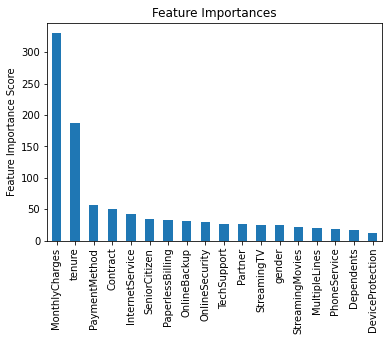

In [108]:
get_feature_importances(first_model)

Second Prediction: Using intial Parameters and removing features of least importances

# Model after removing the features of least importance.

In [109]:
dropl=['DeviceProtection','Dependents','Dependents','gender','StreamingMovies','MultipleLines']

In [110]:
dropl_first=dropl+[target,IDcol]

In [111]:
# These are the initial parameters before tuning.
predictors = drop_features(dropl_first)
xgb1 = XgbClass()
second_model=modelfit(xgb1, train, predictors)

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 40, 'nthread': 1, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'subsample': 0.8, 'verbosity': 1}


In [112]:
get_accuracy(second_model,predictors)


Model Report
Accuracy : 0.8213
AUC Score (Train): 0.869170


the score remains the same we must predict for the last time to see if our model if accurate enough to classify

MonthlyCharges      360
tenure              232
PaymentMethod        65
Contract             50
InternetService      45
OnlineBackup         37
PaperlessBilling     37
StreamingTV          35
SeniorCitizen        35
OnlineSecurity       35
TechSupport          30
PhoneService         30
Partner              24
dtype: int64


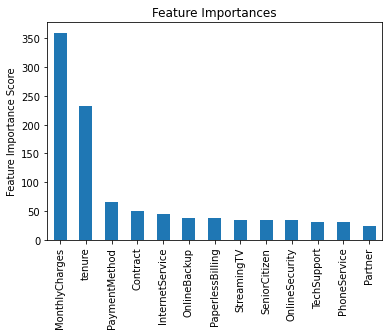

In [113]:
get_feature_importances(second_model)

Third Prediction: Again removing the features of least importance


In [114]:
dropl1=dropl+['Partner','PhoneService','OnlineBackup','TechSupport','OnlineSecurity']
dropl_second=dropl_first+['Partner','PhoneService','OnlineBackup','TechSupport','OnlineSecurity']

In [115]:
predictors=drop_features(dropl_second)

In [116]:
xgb1=XgbClass()
third_model=modelfit(xgb1,train,predictors)

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 38, 'nthread': 1, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'subsample': 0.8, 'verbosity': 1}


In [117]:
get_accuracy(third_model,predictors)


Model Report
Accuracy : 0.8099
AUC Score (Train): 0.864332


In [ ]:
# Tune max_depth and min_child_weight.

In [118]:
predictors = drop_features(dropl_first)
predictors

['SeniorCitizen',
 'Partner',
 'tenure',
 'PhoneService',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'TechSupport',
 'StreamingTV',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges']

In [119]:
param_test1 = {
 'max_depth':list(range(5,10,1)),
 'min_child_weight':list(range(5,10,1))
}
gsearch1 = GridSearchCV(estimator=XgbClass(n_estimators=48),param_grid =param_test1,
                        scoring='roc_auc',n_jobs=-1,iid=False, cv=5, verbose=3)
gsearch1.fit(train[predictors],train[target])
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   23.3s finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'mean_fit_time': array([0.26410842, 0.26208167, 0.25526834, 0.25657258, 0.25788884,
         0.30191689, 0.30354962, 0.29791255, 0.29617548, 0.29707203,
         0.35022049, 0.3435461 , 0.34039836, 0.33574376, 0.3287231 ,
         0.38328905, 0.37785254, 0.37844982, 0.36418419, 0.35946898,
         0.41211572, 0.40416107, 0.3963326 , 0.40213575, 0.36866202]),
  'mean_score_time': array([0.00874104, 0.00901842, 0.01040559, 0.00760822, 0.00755024,
         0.00806837, 0.00839858, 0.00808525, 0.0080687 , 0.00795264,
         0.00855908, 0.00870218, 0.00891957, 0.00852246, 0.00856881,
         0.00931368, 0.00935297, 0.01032624, 0.00929375, 0.00871334,
         0.00913224, 0.00945225, 0.00926738, 0.00906   , 0.00842772]),
  'mean_test_score': array([0.84387038, 0.84395235, 0.84404108, 0.84410559, 0.84513053,
         0.84298373, 0.84229549, 0.84230745, 0.84224743, 0.84370115,
         0.84021957, 0.83934082, 0.84108795, 0.8421241 , 0.8419951 ,
         0.83888252, 0.83870978, 0.8402687 ,

In [120]:
# If the best parameters are edge values then we do 
# GridSearchCV by taking one less and one value more than the best parameters.

In [121]:
param_test2 = {
 'max_depth':[6,7,8,9],
 'min_child_weight':[2,3,4,5]
}
gsearch2 = GridSearchCV(estimator=XgbClass(n_estimators=48),param_grid =param_test2,scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'mean_fit_time': array([0.31151896, 0.31238809, 0.31021428, 0.30437026, 0.35795479,
         0.35517511, 0.35776405, 0.34621825, 0.40524025, 0.39627275,
         0.38686867, 0.3827302 , 0.44333677, 0.4328661 , 0.42368603,
         0.40697203]),
  'mean_score_time': array([0.01085892, 0.01096048, 0.00891838, 0.00850801, 0.01124802,
         0.00895605, 0.00899448, 0.00952148, 0.01167321, 0.00961862,
         0.01014566, 0.01268625, 0.01082449, 0.0128706 , 0.00990849,
         0.00879483]),
  'mean_test_score': array([0.83951631, 0.84120099, 0.84185271, 0.84298373, 0.83745312,
         0.8385824 , 0.83950819, 0.84021957, 0.83465064, 0.83582427,
         0.83763901, 0.83888252, 0.83404724, 0.83563122, 0.83645468,
         0.8376805 ]),
  'param_max_depth': masked_array(data=[6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 9, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False, False, False, False, False],
         fi

In [129]:
xgb1 = XgbClass(max_depth=6,min_child_weight=5)
model=modelfit(xgb1, train, predictors)

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 5, 'missing': None, 'n_estimators': 40, 'nthread': 1, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'subsample': 0.8, 'verbosity': 1}


In [130]:
get_accuracy(model,predictors)


Model Report
Accuracy : 0.8355
AUC Score (Train): 0.876265


In [124]:
# To tune gamma.

In [125]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,8)]
}
gsearch3=GridSearchCV(estimator=XgbClass(n_estimators=48,max_depth=7,min_child_weight=5),
                      param_grid =param_test3,scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'mean_fit_time': array([0.35082102, 0.36061034, 0.35498171, 0.34816809, 0.34749365,
         0.34468617, 0.34682245, 0.34092097]),
  'mean_score_time': array([0.01040044, 0.0095253 , 0.00879412, 0.00934381, 0.00937304,
         0.01116095, 0.00910974, 0.00962448]),
  'mean_test_score': array([0.84021957, 0.84079808, 0.84094814, 0.83973531, 0.83901924,
         0.8398556 , 0.83964386, 0.84051657]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
               mask=[False, False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4},
   {'gamma': 0.5},
   {'gamma': 0.6},
   {'gamma': 0.7}],
  'rank_test_score': array([4, 2, 1, 6, 8, 5, 7, 3], dtype=int32),
  'split0_test_score': array([0.85205022, 0.85525005, 0.85519178, 0.85402098, 0.85264357,
         0.85206082, 0.85342234, 0.85366073]),
  'split1_test_score'

In [131]:
xgb1 = XgbClass(max_depth=7,min_child_weight=5,gamma=0.2)
model=modelfit(xgb1, train, predictors)

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 5, 'missing': None, 'n_estimators': 32, 'nthread': 1, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'subsample': 0.8, 'verbosity': 1}


In [132]:
get_accuracy(model,predictors)


Model Report
Accuracy : 0.8468
AUC Score (Train): 0.877427


In [133]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4=GridSearchCV(estimator=XgbClass(n_estimators=48,max_depth=7,
                                         min_child_weight=5,gamma=0.2),
                      param_grid =param_test4,scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'mean_fit_time': array([0.30702691, 0.2999589 , 0.29474344, 0.28649006, 0.33342314,
         0.34540424, 0.3287293 , 0.32240639, 0.35087743, 0.3503058 ,
         0.34684515, 0.33713002, 0.36676764, 0.36878023, 0.36106634,
         0.3424747 ]),
  'mean_score_time': array([0.00911303, 0.00906029, 0.00908346, 0.01026382, 0.00877628,
         0.00890112, 0.00865779, 0.00930495, 0.00860991, 0.00888314,
         0.00917587, 0.00869722, 0.0086092 , 0.00869451, 0.00912766,
         0.00814185]),
  'mean_test_score': array([0.84216239, 0.84171961, 0.84022659, 0.84042805, 0.84153772,
         0.84184878, 0.84075318, 0.84037679, 0.84160709, 0.84080024,
         0.84094814, 0.83939176, 0.84168531, 0.84100167, 0.83956506,
         0.83847787]),
  'param_colsample_bytree': masked_array(data=[0.6, 0.6, 0.6, 0.6, 0.7, 0.7, 0.7, 0.7, 0.8, 0.8, 0.8,
                     0.8, 0.9, 0.9, 0.9, 0.9],
               mask=[False, False, False, False, False, False, False, False,
                     False, F

In [138]:
xgb1 = XgbClass(max_depth=6,min_child_weight=7,gamma=0.2,subsample=0.7,colsample_bytree=0.7)
model=modelfit(xgb1, train, predictors)

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.7, 'gamma': 0.2, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 7, 'missing': None, 'n_estimators': 34, 'nthread': 1, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'subsample': 0.7, 'verbosity': 1}


In [139]:
get_accuracy(model,predictors)


Model Report
Accuracy : 0.834
AUC Score (Train): 0.865270


In [140]:
#dropl1=dropl+['Partner','PhoneService','OnlineBackup','TechSupport','OnlineSecurity']
# RunTestAndSaveResults(dropl,'final_result.csv',model)
#FixMeLater the final_result file is not printing to csv

In [141]:
ls -l

total 8
drwx------ 5 root root 4096 Jun 10 10:50 drive/
drwxr-xr-x 1 root root 4096 Jun  1 13:40 sample_data/
